<a href="https://colab.research.google.com/github/jwNien/CS_5834_urban_computing_final_project/blob/main/Taxi_fee_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
import os
weather_data_path = '/content/gdrive/MyDrive/urbcomp_fall2024/final_project/Washington D.C. area 2024-07-01 to 2024-07-31.csv'
taxi_data_path = '/content/gdrive/MyDrive/urbcomp_fall2024/final_project/taxi_2024_07.csv'

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
# Load datasets
weather_data = pd.read_csv(weather_data_path)
taxi_data = pd.read_csv(taxi_data_path)

In [4]:
# 1. Filter Taxi Data for TRIPTYPE = 'Ordinal'
taxi_data_filtered = taxi_data[taxi_data['TRIPTYPE'] == 'Ordinal']

In [5]:
# 2. Select relevant columns for the taxi data
columns_to_keep = [
    'FAREAMOUNT', 'ORIGINCITY', 'ORIGINSTATE', 'DESTINATIONCITY', 'DESTINATIONSTATE',
    'MILEAGE', 'DURATION', 'ORIGIN_BLOCK_LATITUDE', 'ORIGIN_BLOCK_LONGITUDE',
    'DESTINATION_BLOCK_LAT', 'DESTINATION_BLOCK_LONG', 'AIRPORT',
    'ORIGINDATETIME_TR', 'DESTINATIONDATETIME_TR'
]
taxi_data_filtered = taxi_data_filtered[columns_to_keep]

In [6]:
# 3. Parse datetime for taxi data
taxi_data_filtered['ORIGINDATETIME_TR'] = pd.to_datetime(taxi_data_filtered['ORIGINDATETIME_TR'], errors='coerce')
taxi_data_filtered['DESTINATIONDATETIME_TR'] = pd.to_datetime(taxi_data_filtered['DESTINATIONDATETIME_TR'], errors='coerce')

# Extract time only from datetime
taxi_data_filtered['pickup_time'] = taxi_data_filtered['ORIGINDATETIME_TR'].dt.time

# Add drop-off time
taxi_data_filtered['dropoff_time'] = taxi_data_filtered['DESTINATIONDATETIME_TR'].dt.time

# Convert AIRPORT to binary (0 or 1)
taxi_data_filtered['AIRPORT'] = taxi_data_filtered['AIRPORT'].apply(lambda x: 1 if x == 'Y' else 0)

<ipython-input-6-8db066e2a810>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_data_filtered['ORIGINDATETIME_TR'] = pd.to_datetime(taxi_data_filtered['ORIGINDATETIME_TR'], errors='coerce')
<ipython-input-6-8db066e2a810>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_data_filtered['DESTINATIONDATETIME_TR'] = pd.to_datetime(taxi_data_filtered['DESTINATIONDATETIME_TR'], errors='coerce')


In [7]:
# 4. Preprocess Weather Data
# Convert datetime column to datetime format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], errors='coerce')

# Extract time only from datetime for weather data
weather_data['time'] = weather_data['datetime'].dt.time

# Extract relevant columns from the weather data
weather_columns_to_keep = ['time', 'temp', 'humidity', 'precip', 'windgust', 'conditions']
weather_data = weather_data[weather_columns_to_keep]

# Normalize numerical weather data
numerical_weather_cols = ['temp', 'humidity', 'precip', 'windgust']
scaler = MinMaxScaler()
weather_data[numerical_weather_cols] = scaler.fit_transform(weather_data[numerical_weather_cols])

<ipython-input-7-2a1b809d3083>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data[numerical_weather_cols] = scaler.fit_transform(weather_data[numerical_weather_cols])


In [8]:
# 5. Merge Weather Data with Taxi Data
# Merge on time (pickup time)
combined_data = pd.merge(
    taxi_data_filtered,
    weather_data,
    left_on='pickup_time',
    right_on='time',
    how='left'
)

# Drop the extra time column from weather data
combined_data.drop(columns=['time'], inplace=True)

In [9]:
# 6. Handle Missing Values
# Fill missing weather values with mean for numerical columns and mode for categorical
for col in numerical_weather_cols:
    combined_data[col] = combined_data[col].fillna(combined_data[col].mean())

combined_data['conditions'] = combined_data['conditions'].fillna(combined_data['conditions'].mode()[0])

# Drop rows with missing values in essential columns
essential_columns = ['FAREAMOUNT', 'MILEAGE', 'DURATION', 'ORIGIN_BLOCK_LATITUDE', 'ORIGIN_BLOCK_LONGITUDE']
combined_data.dropna(subset=essential_columns, inplace=True)

In [10]:
# 7. Feature Engineering
# Add time of day feature
combined_data['time_of_day'] = pd.to_datetime(combined_data['pickup_time'], format='%H:%M:%S').dt.hour
combined_data['time_of_day'] = pd.cut(
    combined_data['time_of_day'],
    bins=[0, 6, 12, 18, 24],
    labels=['Midnight', 'Morning', 'Afternoon', 'Evening'],
    right=False
)

# Encode categorical features using Label Encoding to reduce feature numbers
categorical_features = ['ORIGINCITY', 'ORIGINSTATE', 'DESTINATIONCITY', 'DESTINATIONSTATE', 'conditions', 'time_of_day']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    combined_data[feature] = le.fit_transform(combined_data[feature].astype(str))
    label_encoders[feature] = le

# Normalize geospatial and other numerical features
numerical_features = ['MILEAGE', 'DURATION', 'ORIGIN_BLOCK_LATITUDE', 'ORIGIN_BLOCK_LONGITUDE', 'DESTINATION_BLOCK_LAT', 'DESTINATION_BLOCK_LONG']
combined_data[numerical_features] = scaler.fit_transform(combined_data[numerical_features])

In [11]:
# Encode time-related features from datetime columns
combined_data['pickup_hour'] = pd.to_datetime(combined_data['ORIGINDATETIME_TR']).dt.hour
combined_data['pickup_day'] = pd.to_datetime(combined_data['ORIGINDATETIME_TR']).dt.dayofweek
combined_data['dropoff_hour'] = pd.to_datetime(combined_data['DESTINATIONDATETIME_TR']).dt.hour
combined_data['dropoff_day'] = pd.to_datetime(combined_data['DESTINATIONDATETIME_TR']).dt.dayofweek

In [12]:
# Convert time features to cyclic encoding (to capture periodicity)
combined_data['pickup_hour_sin'] = np.sin(2 * np.pi * combined_data['pickup_hour'] / 24)
combined_data['pickup_hour_cos'] = np.cos(2 * np.pi * combined_data['pickup_hour'] / 24)
combined_data['dropoff_hour_sin'] = np.sin(2 * np.pi * combined_data['dropoff_hour'] / 24)
combined_data['dropoff_hour_cos'] = np.cos(2 * np.pi * combined_data['dropoff_hour'] / 24)

# Drop the original time-related features
combined_data.drop(columns=['pickup_hour', 'dropoff_hour'], inplace=True)

In [13]:
# Remove outliers based on fare amount
y_threshold = combined_data['FAREAMOUNT'].quantile(0.99)  # Keep only the lower 99% of fares
combined_data = combined_data[combined_data['FAREAMOUNT'] <= y_threshold]

In [14]:
combined_data = combined_data.sample(frac=0.1, random_state=42)

In [14]:
# Final preprocessed data
print("Preprocessing complete. Combined and encoded dataset ready.")
combined_data.head()

Preprocessing complete. Combined and encoded dataset ready.


,FAREAMOUNT,ORIGINCITY,ORIGINSTATE,DESTINATIONCITY,DESTINATIONSTATE,MILEAGE,DURATION,ORIGIN_BLOCK_LATITUDE,ORIGIN_BLOCK_LONGITUDE,DESTINATION_BLOCK_LAT,...,precip,windgust,conditions,time_of_day,pickup_day,dropoff_day,pickup_hour_sin,pickup_hour_cos,dropoff_hour_sin,dropoff_hour_cos
2357251,17.56,33,1,307,10,0.023639,0.005468,0.494950,0.437249,NaN,...,0.01918,0.098139,3,3,6,6,0.707107,-0.707107,0.707107,-0.707107
743851,18.60,32,1,476,2,0.023295,0.006792,0.566990,0.452567,0.284738,...,0.00000,0.067682,2,1,4,4,-0.866025,0.500000,-0.866025,0.500000
794646,29.71,33,1,479,2,0.023725,0.009499,0.476201,0.279854,0.630343,...,0.00000,0.067682,1,2,5,5,0.500000,0.866025,0.707107,0.707107
5483656,8.38,33,1,479,2,0.005845,0.004702,0.400756,0.546945,0.442279,...,0.00000,0.219966,2,1,0,0,-0.866025,0.500000,-0.866025,0.500000
4744095,37.85,33,1,468,6,0.041690,0.008428,0.432814,0.354612,NaN,...,0.00000,0.128596,2,1,3,3,-0.965926,0.258819,-0.965926,0.258819


In [15]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Drop original datetime columns
X = combined_data.drop(columns=['FAREAMOUNT', 'ORIGINDATETIME_TR', 'DESTINATIONDATETIME_TR'])
y = combined_data['FAREAMOUNT']

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)  # Replace any remaining NaN values with 0

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
def safe_mape(y_true, y_pred):
    non_zero_indices = y_true != 0  # Filter out zero values
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100


In [19]:
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = safe_mape(y_test.values, predictions)
    print(f"{model_name} Performance:")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Percentage Error: {mape}%\n")

In [20]:
# Feature Importance Function
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importance - {model_name}")
        plt.bar(range(X_train.shape[1]), importance[indices], align="center")
        plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
        plt.tight_layout()
        plt.show()

In [ ]:
# 1. Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
evaluate_model(linear_model, X_test, y_test, "Linear Regression")

Linear Regression Performance:
Mean Absolute Error: 2.084199065643162
Mean Squared Error: 10.790873233371718
R^2 Score: 0.8909313715199124
Mean Absolute Percentage Error: 18.17764823179622%



Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 10}
Decision Tree Regressor Performance:
Mean Absolute Error: 0.0007815411138345364
Mean Squared Error: 0.014812330013607072
R^2 Score: 0.9998502845428503
Mean Absolute Percentage Error: 0.033246425954807486%



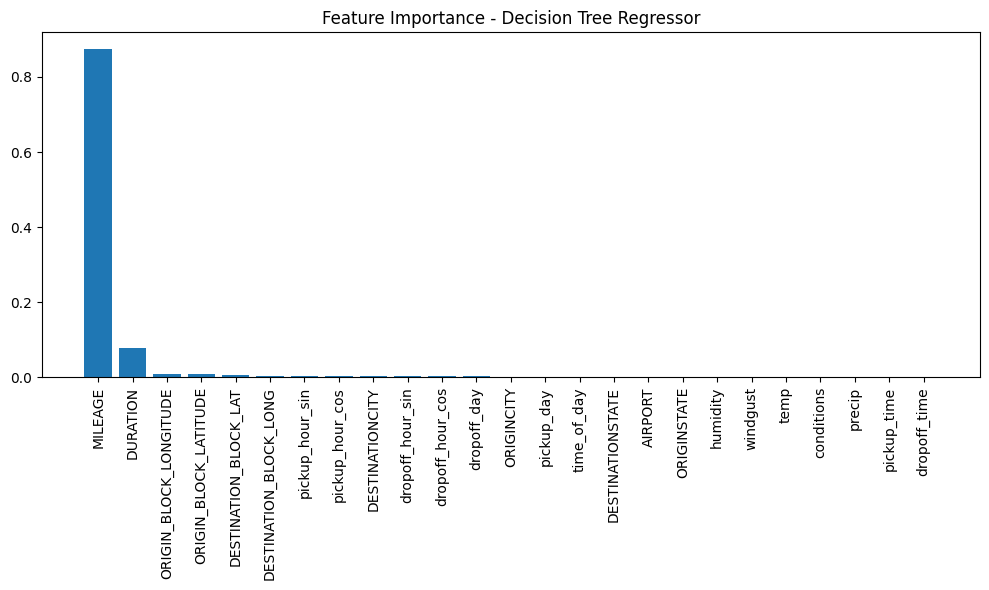

In [ ]:
# 2. Decision Tree Regressor with Hyperparameter Tuning
dt_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}
dt_model = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error')
dt_model.fit(X_train, y_train)
print(f"Best Parameters for Decision Tree: {dt_model.best_params_}")
evaluate_model(dt_model.best_estimator_, X_test, y_test, "Decision Tree Regressor")
plot_feature_importance(dt_model.best_estimator_, X.columns, "Decision Tree Regressor")

Random Forest Regressor Performance:
Mean Absolute Error: 0.41162325381047066
Mean Squared Error: 1.0373468333642981
R^2 Score: 0.9895243786740884
Mean Absolute Percentage Error: 3.764848400087528%



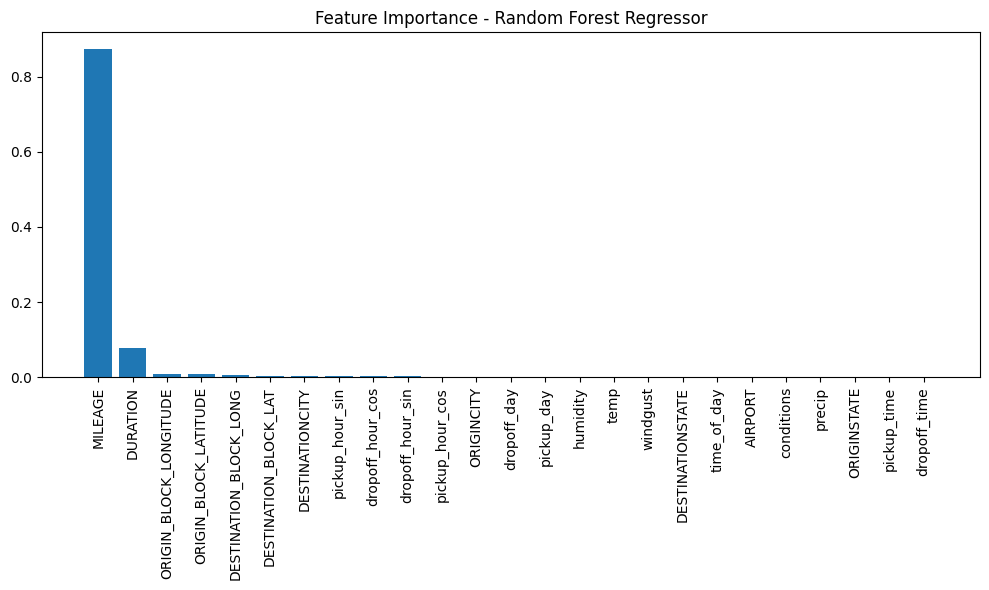

In [22]:
# 3. Random Forest Regressor with Hyperparameter Tuning
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Random Forest Regressor")
plot_feature_importance(rf_model, X.columns, "Random Forest Regressor")

Gradient Boosting Regressor Performance:
Mean Absolute Error: 1.3636117685400824
Mean Squared Error: 5.922364906229883
R^2 Score: 0.9401931445528933
Mean Absolute Percentage Error: 11.488296936199161%



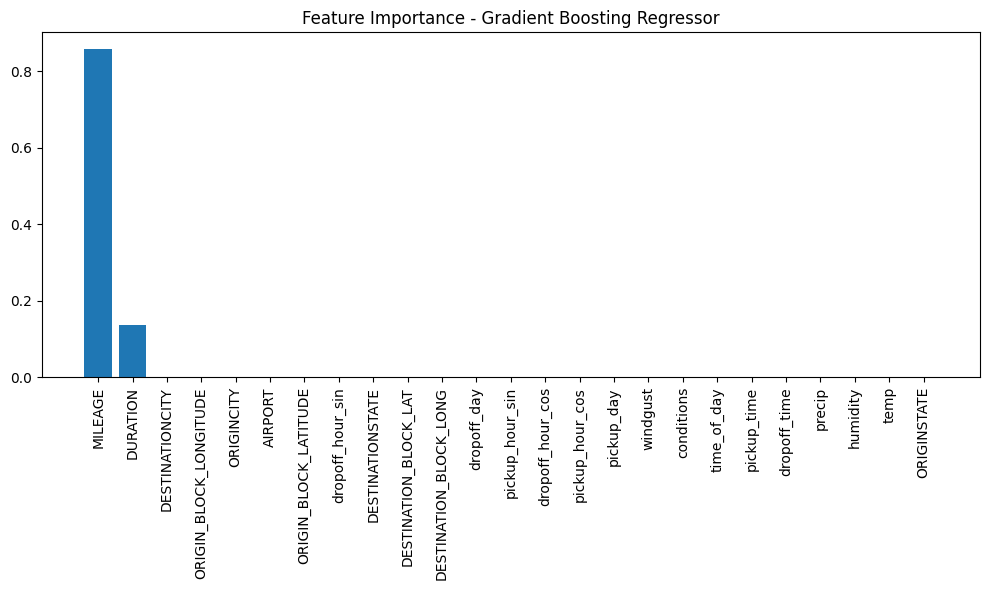

In [ ]:
# 4. Gradient Boosting Regressor with Hyperparameter Tuning
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
evaluate_model(gb_model, X_test, y_test, "Gradient Boosting Regressor")
plot_feature_importance(gb_model, X.columns, "Gradient Boosting Regressor")

In [ ]:
# 5. Neural Network Regressor (MLP) with Hyperparameter Tuning
mlp_params = {
    'hidden_layer_sizes': [(100,), (100, 50), (100, 100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200, 500]
}
#Remove GridSearchCV and fit with default parameters:
mlp_model = MLPRegressor(random_state=42)
mlp_model.fit(X_train, y_train)
#Remove best_params_ and best_estimator_:
evaluate_model(mlp_model, X_test, y_test, "Neural Network Regressor")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Regressor Performance:
Mean Absolute Error: 1.9772457637150427
Mean Squared Error: 9.761436649881432
R^2 Score: 0.90142437355364
Mean Absolute Percentage Error: 14.96114298850527%



In [34]:
# Drop original datetime columns
X = combined_data.drop(columns=['FAREAMOUNT', 'ORIGINDATETIME_TR', 'DESTINATIONDATETIME_TR'])
y = combined_data['FAREAMOUNT']

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)  # Replace any remaining NaN values with 0

In [51]:
# Check the number of features in X_test
num_features_x_test = X_test.shape[1]
print(f"Number of features in X_test: {num_features_x_test}")

# Check the number of samples in y_test
num_samples_y_test = y_test.shape[0]
print(f"Number of samples in y_test: {num_samples_y_test}")

Number of features in X_test: 23
Number of samples in y_test: 95067


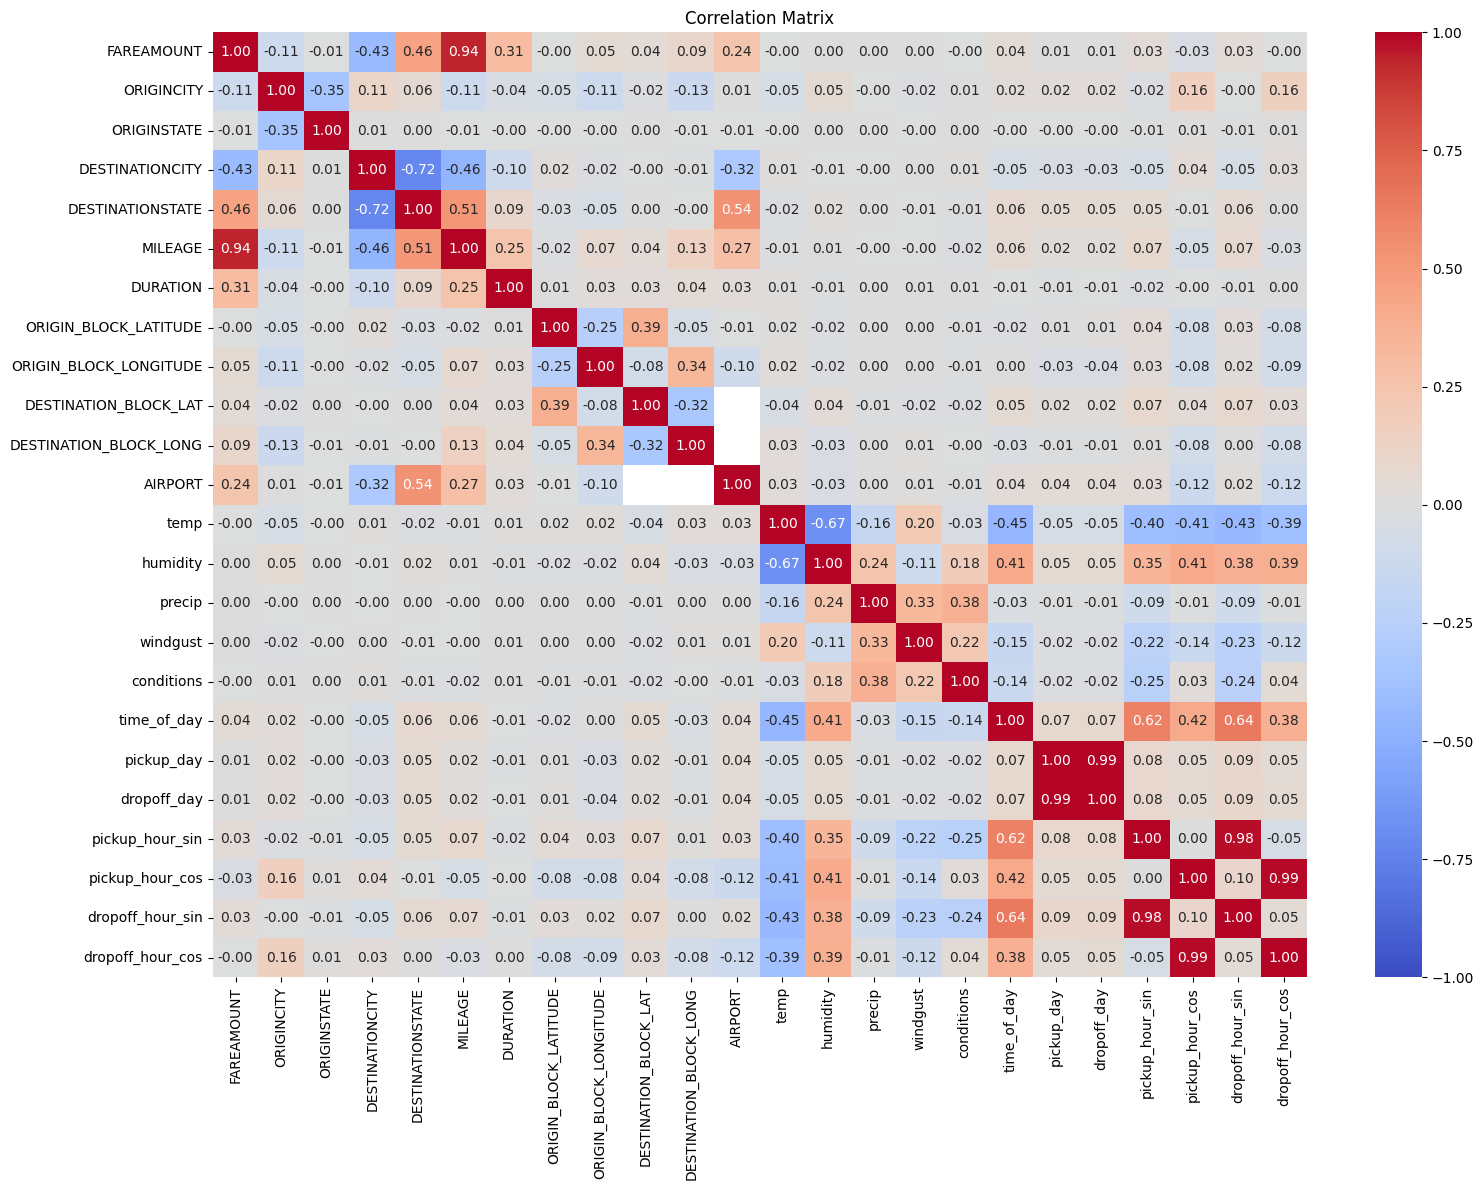

In [46]:
# 6. Correlation Analysis
plt.figure(figsize=(16, 12))

# Exclude columns with datetime.time type before calculating correlation
# Instead of 'datetime.time', use the actual data type of your columns, which is likely 'object' for datetime.time objects.
numeric_combined_data = combined_data.select_dtypes(exclude=['datetime64[ns]', 'object'])

corr_matrix = numeric_combined_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

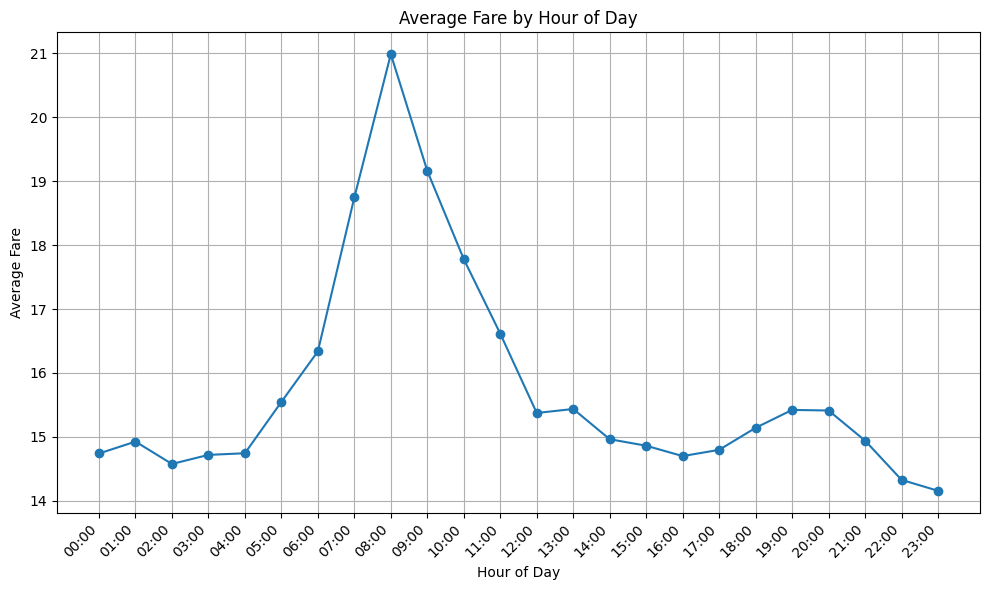

In [50]:
# 8. Temporal Analysis
temporal_analysis = combined_data.groupby('pickup_time')['FAREAMOUNT'].mean()
plt.figure(figsize=(10, 6))

# Convert datetime.time objects to strings for plotting
# and then format them to extract the hour
x_values = [t.strftime('%H:%M') for t in temporal_analysis.index]

plt.plot(x_values, temporal_analysis.values, marker='o')
plt.title("Average Fare by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid()
plt.tight_layout()
plt.show()

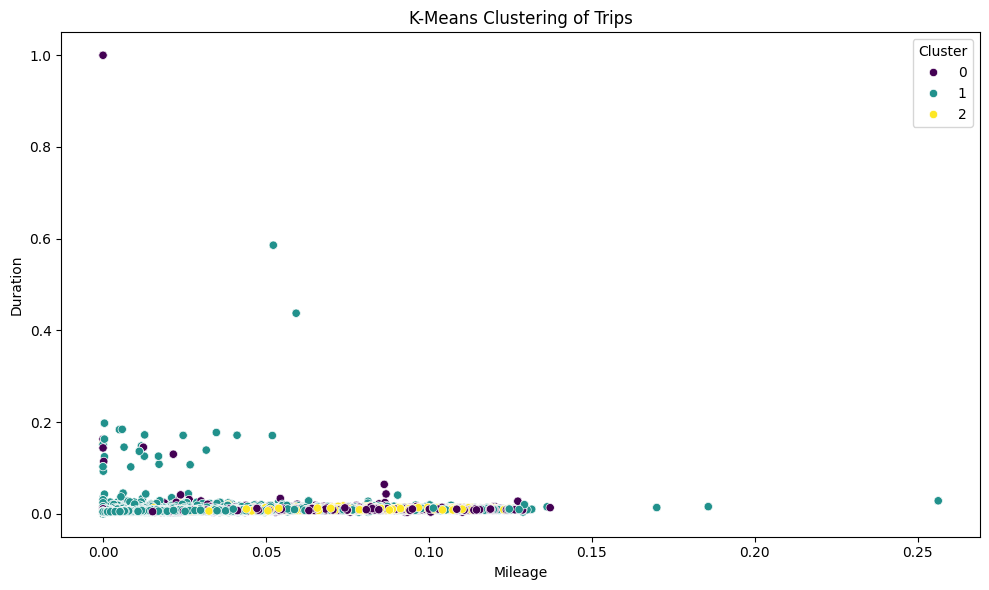

In [27]:
# 9. Clustering Analysis (K-Means)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
combined_data['cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(x=combined_data['MILEAGE'], y=combined_data['DURATION'], hue=combined_data['cluster'], palette='viridis')
plt.title("K-Means Clustering of Trips")
plt.xlabel("Mileage")
plt.ylabel("Duration")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()